## Pick stimulus

- from initial reading of max and mins

In [1]:
from starling_rhythm.utils.paths import PROCESSED_DIR

In [2]:
bID = 's_b1555_22'
SAVE_PATH = PROCESSED_DIR / bID / 'shuffle_tmf.pickle'

In [3]:
import pandas as pd

In [4]:
shuffle_tmf = pd.read_pickle(SAVE_PATH)

## Original calculation. 

In [5]:
shuffle_tmf.head()

,index,shuffle_wavs,shuffle_og_seg,shuffle_ts,seg_nb,type
18,18,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...,s_b1555_22_2022-09-20_09-00-01-01_1611695_1641...,33.540317,0,max
1,1,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...,s_b1555_22_2022-09-20_09-00-01-01_1611695_1641...,13.189624,0,min
3,35,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...,s_b1555_22_2022-09-20_09-00-01-02_1242225_1285...,48.723433,1,max
30,62,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...,s_b1555_22_2022-09-20_09-00-01-02_1242225_1285...,24.444802,1,min
19,83,/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...,s_b1555_22_2022-09-20_09-00-01-02_1242225_1285...,43.137802,2,max


In [6]:
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

/tmp/ipykernel_10710/123448108.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [7]:
from starling_rhythm.mfdfa import tmf
n_jobs = 36
verbose = 0

## Do a power analysis

In [8]:
import numpy as np
from statsmodels.stats.power import TTestPower
import matplotlib.pyplot as plt

In [9]:
solver = TTestPower()
solver.solve_power(effect_size = 0.5, nobs = 100, alpha = 0.05, power = None, alternative = "two-sided")

0.9986097138390777

## Check crank ns

In [10]:
shuffle_wavs = shuffle_tmf['shuffle_wavs'].values

In [11]:
import seaborn as sns

<AxesSubplot:xlabel='shuffle_ts', ylabel='Count'>

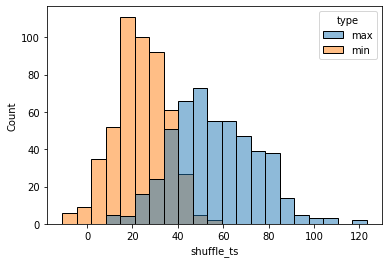

In [12]:
sns.histplot(data = shuffle_tmf.reset_index(), x = 'shuffle_ts', hue = 'type')

In [13]:
## we know from this that there is a population difference when we run a second time. 
## Let's run 36 of each, and take the sample mean, and take that as the true t statistic of the recording

In [19]:
def tmf_n(
    address, 
    ns = 32, 
    amp_env_sr = 200,
    n = 36
):

    with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
        SDoTMF = parallel(
            delayed(tmf)(
                address,
                ns = 32,
                amp_env_sr = 200,
                z = True
            )
            for i in tqdm(np.arange(0, n), desc = 'shuffle')
        )
        
    return SDoTMF

In [20]:
tester = shuffle_wavs[0]

In [21]:
tester

PosixPath('/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_b1555_22/templatingFalse-shuffle/s_b1555_22_2022-09-20_09-00-01-01_1611695_1641125_seg_20.0_30.0_templatingFalse-shuffle_26_.wav')

In [22]:
## Compare empirical MF of the tester to 2/5/10/32/64/128 surrogates 30 times, 
## and give the std of t of these 30 times

In [23]:
np.std(tmf_n(tester, ns = 2, n = 30))

shuffle: 100%|██████████| 30/30 [00:00<00:00, 55899.21it/s]


0.6908306459453253

In [24]:
np.std(tmf_n(tester, ns = 5, n = 30))

shuffle: 100%|██████████| 30/30 [00:00<00:00, 71250.92it/s]


0.5620762404231633

In [25]:
np.std(tmf_n(tester, ns = 10, n = 30))

shuffle: 100%|██████████| 30/30 [00:00<00:00, 70217.14it/s]


0.4784462512129092

In [26]:
np.std(tmf_n(tester, ns = 32, n = 30))

shuffle: 100%|██████████| 30/30 [00:00<00:00, 74764.78it/s]


0.6011729142535095

In [27]:
np.std(tmf_n(tester, ns = 64, n = 30))

shuffle: 100%|██████████| 30/30 [00:00<00:00, 78057.77it/s]


0.5428013953363973

In [28]:
np.std(tmf_n(tester, ns = 128, n = 30))

shuffle: 100%|██████████| 30/30 [00:00<00:00, 67360.34it/s]


0.6122856372863272